# Difftest Results

Import prereqs and connect to results database:

In [1]:
import sqlalchemy as sql
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import datetime
import humanize

from collections import OrderedDict
from matplotlib.ticker import FuncFormatter
from collections import OrderedDict
from labm8 import fs, viz

def cache_time(path):
    modified = datetime.datetime.fromtimestamp(os.path.getmtime(path))
    diff = datetime.datetime.now() - modified
    return humanize.naturaltime(diff) + " ({})".format(modified)

%matplotlib inline
sns.set(style="ticks", color_codes=True)
plt.style.use(["seaborn-white", "seaborn-paper"])

import db
from db import *
%run util.py

TIME_LIMIT = 48 * 3600
TIMEOUT = 60

hostname = "cc1"
db.init(hostname)

'mysql://cc1:3306/project_b'

## Overview

Summary of testing results:

In [12]:
!rm -fv ../data/difftest/overview.csv

removed '../data/difftest/overview.csv'


In [3]:
def get_device_stats(s, tables, testbed_id, no_opt):
    devname = device_str(s.query(Testbed).filter(Testbed.id == testbed_id).first().device)
    
    optimizations = not no_opt
    param_ids = s.query(tables.params.id)\
        .filter(tables.params.optimizations == optimizations)
    
    num_results = s.query(sql.sql.func.count(tables.results.id))\
        .join(tables.testcases)\
        .filter(tables.results.testbed_id == testbed_id,
                tables.testcases.params_id.in_(param_ids)).scalar()

    total_time = int(s.query(tables.meta.cumtime)\
        .join(tables.results)\
        .join(tables.testcases)\
        .filter(tables.results.testbed_id == testbed_id,
                tables.testcases.params_id.in_(param_ids))\
        .order_by(tables.meta.cumtime.desc()).first()[0])

    print(f"\r\033[1K{tables.name} {devname}",
          "no-opt" if no_opt else "opt",
          f"results: {num_results} time: {total_time:.0f}s", end="")
    return num_results, total_time


def get_device_overview(s, testbed_id):
    testbed = s.query(Testbed).filter(Testbed.id == testbed_id).first()
    
    clsmith_noopt_results, clsmith_noopt_time = get_device_stats(s, CLSMITH_TABLES, testbed_id, True)
    clsmith_results, clsmith_time = get_device_stats(s, CLSMITH_TABLES, testbed_id, False)

    clgen_noopt_results, clgen_noopt_time = get_device_stats(s, CLGEN_TABLES, testbed_id, True)
    clgen_results, clgen_time = get_device_stats(s, CLGEN_TABLES, testbed_id, False)
    
    r1 = OrderedDict()
    r1["Device"] = device_str(testbed.device)
    r1["±"] = "-"
    r1["CLSmith time"] = clsmith_noopt_time
    r1["CLSmith time (hrs)"] = "{:.1f}h".format(clsmith_noopt_time / 3600)
    r1["CLSmith results"] = clsmith_noopt_results
    r1["CLgen time"] = clgen_noopt_time
    r1["CLgen time (hrs)"] = "{:.1f}h".format(clgen_noopt_time / 3600)
    r1["CLgen results"] = clgen_noopt_results
    
    r2 = OrderedDict()
    r2["Device"] = device_str(testbed.device)
    r2["±"] = "+"
    r2["CLSmith time"] = clsmith_time
    r2["CLSmith time (hrs)"] = "{:.1f}h".format(clsmith_time / 3600)
    r2["CLSmith results"] = clsmith_results
    r2["CLgen time"] = clgen_time
    r2["CLgen time (hrs)"] = "{:.1f}h".format(clgen_time / 3600)
    r2["CLgen results"] = clgen_results
    
    return r1, r2


def get_overview_table():
    cachepath = "../data/difftest/overview.csv"
    
    if fs.exists(cachepath):
        print("cached", cache_time(cachepath))
        return pd.read_csv(cachepath, dtype={
            "CLSmith time": np.int32, "CLgen time": np.int32,
            "CLSmith results": np.int32, "CLgen results": np.int32,
        })
    else:
        rows = []
        with Session(commit=False) as s:
            for config_id, testbed_id in CONFIGURATIONS:
                rows += get_device_overview(s, testbed_id)
        print("\r\033[1K", end="")
        table = pd.DataFrame(rows)
        table.to_csv(cachepath)
        return get_overview_table()


overview_table = get_overview_table()
overview_table

cached 22 minutes ago (2017-07-28 10:35:54.004454)


,Unnamed: 0,Device,±,CLSmith time,CLSmith time (hrs),CLSmith results,CLgen time,CLgen time (hrs),CLgen results
0,0,GeForce GTX 1080,-,223631,62.1h,20002,129547,36.0h,46944
1,1,GeForce GTX 1080,+,240643,66.8h,20002,131244,36.5h,44222
2,2,GeForce GTX 780,-,198831,55.2h,21000,107747,29.9h,57493
3,3,GeForce GTX 780,+,205346,57.0h,21000,91293,25.4h,46068
4,4,Intel HD Haswell GT2,-,217990,60.6h,7957,91076,25.3h,76183
5,5,Intel HD Haswell GT2,+,425220,118.1h,15349,91841,25.5h,76152
6,6,Intel E5-2620 v4,-,206300,57.3h,21000,116374,32.3h,73222
7,7,Intel E5-2620 v4,+,190422,52.9h,21000,107725,29.9h,72803
8,8,Intel E5-2650 v2,-,201876,56.1h,21000,112060,31.1h,60487
9,9,Intel E5-2650 v2,+,241561,67.1h,21000,106637,29.6h,57552


## Schedule

Calculate schedule of remaining jobs which must be ran to meet a minimum time limit.

In [3]:
schedule = []
for _, row in overview_table.iterrows():
    for source in ["CLSmith", "CLgen"]:
        if row[f"{source} time"] < TIME_LIMIT:
            d = OrderedDict()
            d["Device"] = row["Device"]
            d["±"] = row["±"]
            d["Job"] = source
            d["Remaining time"] = (TIME_LIMIT - row[f"{source} time"])
            d["Remaining time (hours)"] = "{:.1f}h".format((TIME_LIMIT - row[f"{source} time"]) / 3600)
            schedule.append(d)

schedule = pd.DataFrame(schedule).sort_values(by="Remaining time", ascending=False) if len(schedule) else "done"
schedule

,Device,±,Job,Remaining time,Remaining time (hours)
4,Intel HD Haswell GT2,-,CLgen,81724,22.7h
3,GeForce GTX 780,+,CLgen,81507,22.6h
5,Intel HD Haswell GT2,+,CLgen,80959,22.5h
15,POCL (Intel E5-2620),+,CLgen,71218,19.8h
18,Oclgrind Simulator,-,CLgen,70540,19.6h
19,Oclgrind Simulator,+,CLgen,69652,19.3h
12,Intel Xeon Phi,-,CLgen,68054,18.9h
9,Intel E5-2650 v2,+,CLgen,66163,18.4h
17,ComputeAorta (Intel E5-2620),+,CLgen,65855,18.3h
7,Intel E5-2620 v4,+,CLgen,65075,18.1h


## Testing Time

Plot total testing time of each configuration.

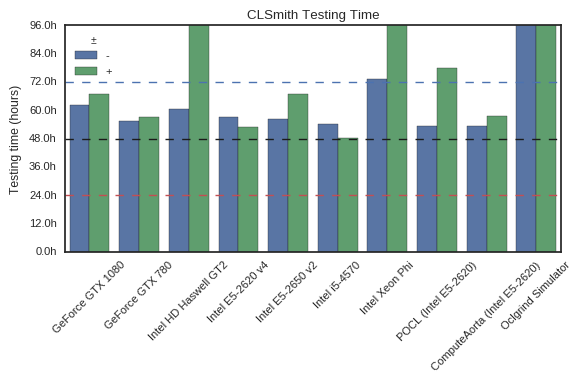

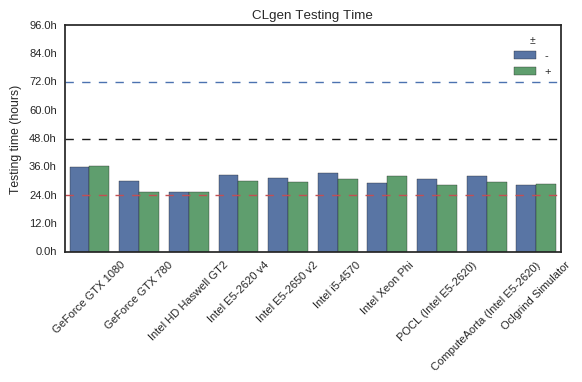

In [4]:
plt.style.use(["seaborn-white", "seaborn-paper"])

def plot_testing_time(table, time_column, title):
    sns.barplot(x="Device", y=time_column, data=overview_table, hue="±")

    ax = plt.gca()

    # X axis
    plt.setp(ax.get_xticklabels(), rotation=45)  # rotate x ticks
    ax.set_xlabel("")

    # Y axis
    ax.set_ylim((0, 96 * 3600))
    plt.yticks(np.arange(0, 100 * 3600, 12 * 3600))
    ax.yaxis.set_major_formatter(FuncFormatter(
        lambda x, pos: "{:.1f}h".format(x / 3600)))
    ax.set_ylabel("Testing time (hours)")
    plt.title(title)

    plt.axhline(y=24 * 3600, color="r", lw=1, linestyle="--")
    plt.axhline(y=48 * 3600, color="k", lw=1, linestyle="--")
    plt.axhline(y=72 * 3600, color="b", lw=1, linestyle="--")

    viz.finalise(figsize=(6, 4))

plot_testing_time(overview_table, "CLSmith time", "CLSmith Testing Time")
plot_testing_time(overview_table, "CLgen time", "CLgen Testing Time")

## Number of Results

Plot the number of results for each configuration.

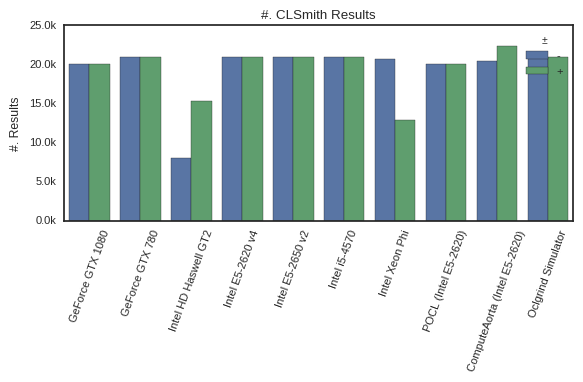

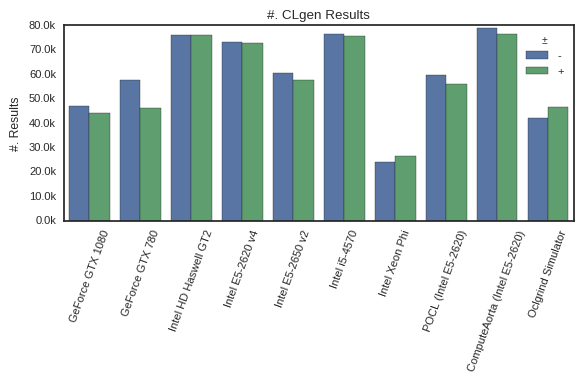

In [5]:
plt.style.use(["seaborn-white", "seaborn-paper"])

def plot_num_results(table, time_column, title):
    sns.barplot(x="Device", y=time_column, data=overview_table, hue="±")

    ax = plt.gca()

    # X axis
    plt.setp(ax.get_xticklabels(), rotation=70)  # rotate x ticks
    ax.set_xlabel("")

    # Y axis
    ax.yaxis.set_major_formatter(FuncFormatter(
        lambda x, pos: "{:.1f}k".format(x / 1000)))
    ax.set_ylabel("#. Results")
    plt.title(title)

    viz.finalise(figsize=(6, 4))

plot_num_results(overview_table, "CLSmith results", "#. CLSmith Results")
plot_num_results(overview_table, "CLgen results", "#. CLgen Results")

## Testbeds

In [6]:
!rm -vf ../data/difftest/testbeds.csv

In [4]:
def get_platform_stats(s, testbed: Testbed):
    num_submitted = s.query(sql.sql.func.count(BugReport.id))\
        .filter(BugReport.testbed_id == testbed.id).scalar() or 0

    # Total time running CLgen tests:
    clgen_time = sum(overview_table.loc[overview_table["Device"] == device_str(testbed.device)]["CLgen time"].values)
    
    # Total time running CLgen reductions:
    reduction_time = s.query(sql.sql.func.sum(CLgenReduction.runtime)).join(CLgenResult)\
        .filter(CLgenResult.testbed_id == testbed.id).scalar() or 0
    
    # Total time from unstructured testing results:
    def get_runtime(table):
        return s.query(sql.sql.func.sum(table.runtime)).filter(table.testbed_id == testbed.id).scalar() or 0
    other_runtimes = sum(get_runtime(table) for table in [coCLgenResult, cl_launcherCLgenResult])

    testing_time = clgen_time + reduction_time + other_runtimes

    return testing_time, num_submitted


def get_row(s, config_id, testbed_id):
    testbed = s.query(Testbed).filter(Testbed.id == testbed_id).first()
    d = OrderedDict()
    d["#."] = config_id
    d["Platform"] = platform_str(testbed.platform)
    d["Device"] = device_str(testbed.device)
    d["Driver"] = driver_str(testbed.driver)
    d["OpenCL"] = testbed.opencl
    d["Operating system"] = host_str(testbed.host)
    d["Device type"] = devtype_str(testbed.devtype)
    runtime, submitted = get_platform_stats(s, testbed)
    d["Testing time"] = "{:.0f} hours".format(round(runtime / 3600))
    d["B.R. Submitted"] = submitted
    return d


def get_testbeds_table():
    cachepath = "../data/difftest/testbeds.csv"
    
    if fs.exists(cachepath):
        print("cached", cache_time(cachepath))
        return pd.read_csv(cachepath, dtype={"B.R. Submitted": np.int32})
    else:
        rows = []
        with Session(commit=False) as s:
            rows += [get_row(s, *x) for x in CONFIGURATIONS]
        table = pd.DataFrame(rows)
        table.to_csv(cachepath, index=False)
        return get_testbeds_table()

testbeds_table = get_testbeds_table()

!cd ~/docs/paper-project_b/ && git pull --rebase
with open(os.path.expanduser("~/docs/paper-project_b/build/tab/platforms.tex"), "w") as outfile:
    print(f"""\
\\begin{{tabular}}{{ cllllll | rR{{1.4cm}} }}
\\toprule
\\textbf{{\\#. }} & \\textbf{{Platform}} & \\textbf{{Device}} & \\textbf{{Driver}} & \\textbf{{OpenCL}} & 
\\textbf{{Operating system}} & \\textbf{{Device Type}} & \\textbf{{Testing time}} & \\textbf{{Bug Reports Submitted}} \\\\
\\midrule""", file=outfile)
    for _, row in testbeds_table.iterrows():
        print(" & ".join([str(x) for x in row]), "\\\\", file=outfile)
    print(f"""
\\bottomrule
\\end{{tabular}}
""", file=outfile)

!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/tab/platforms.tex" && git push
testbeds_table

cached now (2017-07-28 10:58:16.073378)
Current branch master is up to date.
[master 28678d0] auto: build/tab/platforms.tex
 1 file changed, 10 insertions(+), 10 deletions(-)
Counting objects: 5, done.
Delta compression using up to 16 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 498 bytes | 0 bytes/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3)
remote: Updating references: 100% (1/1)
To https://git.overleaf.com/8608915dsywxshwwjmw
   f30ebb3..28678d0  master -> master


,#.,Platform,Device,Driver,OpenCL,Operating system,Device type,Testing time,B.R. Submitted
0,1,NVIDIA CUDA,GeForce GTX 1080,375.39,1.2,Ubuntu 16.04 64bit,GPU,79 hours,7
1,2,NVIDIA CUDA,GeForce GTX 780,361.42,1.2,openSUSE 13.1 64bit,GPU,55 hours,0
2,3,Intel Gen OCL Driver,Intel HD Haswell GT2,1.3,1.2,Ubuntu 16.04 64bit,GPU,51 hours,12
3,4,Intel OpenCL,Intel E5-2620 v4,1.2.0.25,2.0,Ubuntu 16.04 64bit,CPU,68 hours,5
4,5,Intel OpenCL,Intel E5-2650 v2,1.2.0.44,1.2,CentOS 7.1 64bit,CPU,66 hours,1
5,6,Intel OpenCL,Intel i5-4570,1.2.0.25,1.2,Ubuntu 16.04 64bit,CPU,65 hours,4
6,7,Intel OpenCL,Intel Xeon Phi,1.2,1.2,CentOS 7.1 64bit,Accelerator,68 hours,2
7,8,POCL,POCL (Intel E5-2620),0.14,2.0,Ubuntu 16.04 64bit,CPU,64 hours,22
8,9,ComputeAorta,ComputeAorta (Intel E5-2620),1.14,1.2,Ubuntu 16.04 64bit,CPU,62 hours,1
9,10,Oclgrind,Oclgrind Simulator,16.10,1.2,Ubuntu 16.04 64bit,Emulator,61 hours,5


In [ ]:
# %run mkmegatable.ipy

## Runtimes

In [53]:
# delete cached result:
!rm -fv ../data/difftest/runtimes.csv

removed '../data/difftest/runtimes.csv'


In [56]:
def get_runtimes_table():
    """ get runtimes of test case generation, execution, and reduction. cache results to file """
    cachepath = "../data/difftest/runtimes.csv"
    
    if fs.exists(cachepath):
        print("cached", cache_time(cachepath))
        return pd.read_csv(cachepath, dtype={"Runtime (s)": np.float32})
    else:
        with open(cachepath, "w") as outfile:
            print("Source", "Name", "Runtime (s)", sep=',', file=outfile)
            with Session(commit=False) as s:
                for tables in [CLSMITH_TABLES, CLGEN_TABLES]:
                    q = s.query(tables.results.runtime,
                                tables.programs.runtime,
                                sql.sql.func.ifnull(tables.reductions.runtime, 0))\
                        .join(tables.meta)\
                        .join(tables.programs)\
                        .outerjoin(tables.reductions)\
                        .filter(tables.meta.cumtime < TIME_LIMIT)

                    for runtime, generation_time, reduction_time in q:
                        if generation_time < TIMEOUT:
                            print(tables.name, "Generation", generation_time, sep=',', file=outfile)
                        if runtime < TIMEOUT:
                            print(tables.name, "Execution", runtime, sep=',', file=outfile)
                        # no timeout on reductions, but 0 == no reduction
                        if reduction_time > 0:
                            print(tables.name, "Reduction", reduction_time, sep=',', file=outfile)

            return get_runtimes_table()

runtimes_table = get_runtimes_table()
print("loaded", len(runtimes_table), "runtimes")

cached 42 seconds ago (2017-07-26 13:34:53.241378)
loaded 4260274 runtimes


In [57]:
def median_time(source, name):
    return np.mean(runtimes_table[(runtimes_table["Source"] == source) & (runtimes_table["Name"] == name)]["Runtime (s)"].values)

clsmith_medians = np.array([
    median_time("CLSmith", "Generation"),
    median_time("CLSmith", "Execution"),
    median_time("CLSmith", "Reduction"),
])
clgen_medians = np.array([
    median_time("CLgen", "Generation"),
    median_time("CLgen", "Execution"),
    median_time("CLgen", "Reduction"),
])
clsmith_medians
clgen_medians

speedups = clsmith_medians / clgen_medians
speedups

/home/cec/src/project_b/env/python3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/cec/src/project_b/env/python3.6/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


array([ 2.69524693,  4.48198891,         nan], dtype=float32)

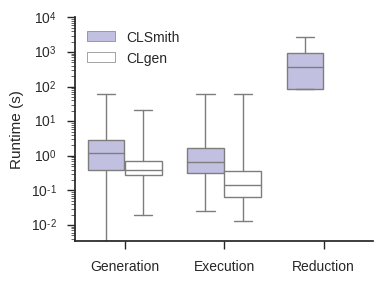

Current branch master is up to date.
[INFO  ] Wrote /home/cec/docs/paper-project_b/build/img/runtimes.pdf
[master f67f72d] auto: build/img/runtimes.pdf
 1 file changed, 0 insertions(+), 0 deletions(-)
Counting objects: 5, done.
Delta compression using up to 16 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 2.66 KiB | 0 bytes/s, done.
Total 5 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2)
remote: Updating references: 100% (1/1)
To https://git.overleaf.com/8608915dsywxshwwjmw
   20450f5..f67f72d  master -> master


In [58]:
sns.set(style="ticks")

def plot_runtimes(runtimes_table, *args, **kwargs):
    # Plot
    palette = sns.cubehelix_palette(2, rot=0, light=.75, dark=1)
    ax = sns.boxplot(
        x="Name", y="Runtime (s)", hue="Source", data=runtimes_table,
        width=.75, linewidth=1, fliersize=.5, whis=np.inf, 
        palette=palette, order=["Generation", "Execution", "Reduction"])

    
    # Y axis
    ax.set_yscale("log", nonposy='clip')
    plt.ylim((0, 10000))

    # X axis
    plt.xlabel("")
    
    # Legend
    ax.get_legend().set_title("")
    plt.legend(loc='upper left')
    ax.get_legend().draw_frame(False)
    
    # Border
    sns.despine(ax=ax)

    viz.finalise(*args, **kwargs)


plot_runtimes(runtimes_table, figsize=(4, 3))

# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
plot_runtimes(runtimes_table, fs.path("~/docs/paper-project_b/build/img/runtimes.pdf"), figsize=(4, 3))
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/img/runtimes.pdf" && git push

## Kernel sizes

In [60]:
def get_kernel_sizes():    
    with Session(commit=False) as s:
        # CLSmith times
        clsmith = s.query(CLSmithResult.classification, CLSmithProgram.src)\
            .join(CLSmithProgram)\
            .join(CLSmithMeta)\
            .filter(CLSmithResult.classification != None,
                    CLSmithResult.classification != "pass",
                    CLSmithMeta.cumtime < TIME_LIMIT)
        clsmith_bc = s.query(CLSmithResult.classification, CLSmithProgram.src)\
            .join(CLSmithProgram)\
            .join(CLSmithMeta)\
            .filter(CLSmithResult.outcome == "bc",
                    CLSmithMeta.cumtime < TIME_LIMIT)

        clgen = s.query(CLgenResult.classification, CLgenProgram.src)\
            .join(CLgenProgram)\
            .join(CLgenMeta)\
            .filter(CLgenResult.classification != None,
                    CLgenResult.classification != "pass",
                    CLgenMeta.cumtime < TIME_LIMIT)
        clgen_bc = s.query(CLgenResult.classification, CLgenProgram.src)\
            .join(CLgenProgram)\
            .join(CLgenMeta)\
            .filter(CLgenResult.outcome == "bc",
                    CLgenMeta.cumtime < TIME_LIMIT)
    
    table = (
        [(classification, len(src.split('\n')), "CLSmith") for classification, src in clsmith] +
        [("bc", len(src.split('\n')), "CLSmith") for _, src in clsmith_bc] +
        [(classification, len(src.split('\n')), "CLgen") for classification, src in clgen] +
        [("bc", len(src.split('\n')), "CLgen") for _, src in clgen_bc])
    
    return pd.DataFrame(table, columns=['Classification', 'Line count', 'Source'])

def get_kernel_sizes_table():
    cachepath = "../data/difftest/kernel-sizes.csv"
    
    if fs.exists(cachepath):
        print("cached", cache_time(cachepath))
        return pd.read_csv(cachepath, dtype={"Line count": np.int32})
    else:
        table = get_kernel_sizes()
        table.to_csv(cachepath)
        return get_kernel_sizes_table()

kernel_sizes_table = get_kernel_sizes_table()
print("loaded", len(kernel_sizes_table), "line counts")

cached now (2017-07-26 13:37:51.113411)
loaded 118622 line counts


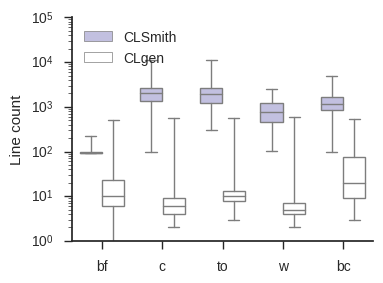

Current branch master is up to date.
[INFO  ] Wrote /home/cec/docs/paper-project_b/build/img/kernel-sizes.pdf
[master 81227a0] auto: build/img/kernel-sizes.pdf
 1 file changed, 0 insertions(+), 0 deletions(-)
Counting objects: 5, done.
Delta compression using up to 16 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 2.90 KiB | 0 bytes/s, done.
Total 5 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2)
remote: Updating references: 100% (1/1)
To https://git.overleaf.com/8608915dsywxshwwjmw
   f67f72d..81227a0  master -> master


In [61]:
def plot_kernel_sizes(table, *args, **kwargs):
    sns.set(style="ticks")
    palette = sns.cubehelix_palette(2, rot=0, light=.75, dark=1)
    ax = sns.boxplot(
        x="Classification", y="Line count", hue="Source", data=table,
        width=.75, linewidth=1, fliersize=.5, whis=np.inf, 
        palette=palette)#, order=["w", "bf", "to"])

    # Y axis
    ax.set_yscale("log", nonposy='clip')
    # plt.ylim((0, 10000))

    # X axis
    plt.xlabel("")
    
    # Legend
    ax.get_legend().set_title("")
    plt.legend(loc='upper left')
    ax.get_legend().draw_frame(False)
    
    # Border
    sns.despine(ax=ax)
    
    viz.finalise(*args, **kwargs)
    
plot_kernel_sizes(kernel_sizes_table, figsize=(4, 3))

# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
plot_kernel_sizes(kernel_sizes_table, fs.path("~/docs/paper-project_b/build/img/kernel-sizes.pdf"), figsize=(4, 3))
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/img/kernel-sizes.pdf" && git push

## Total time

In [ ]:
def get_totaltimes():
    
    def _t(s, results_table, programs_table, reductions_table):
        generation_time = sql.sql.func.ifnull(programs_table.runtime, clgen_generation_time)
        runtime = results_table.runtime
        reduction_time = sql.sql.func.ifnull(reductions_table.runtime, 0)
        total_time = generation_time + runtime + reduction_time

        q = s.query(total_time)\
            .outerjoin(programs_table)\
            .outerjoin(reductions_table)\
            .filter(results_table.classification != None)\
            .order_by(results_table.date)

        times = np.array([row[0] / 3600 for row in q]).cumsum()
        return times
    
    with Session(commit=False) as s:
        clsmith_times = _t(s, CLSmithResult, CLSmithProgram, CLSmithReduction)
        clgen_times = _t(s, CLgenResult, CLgenProgram, CLgenReduction)

    return clsmith_times, clgen_times

clsmith_times, clgen_times = get_totaltimes()

In [ ]:
def plot_total_tests(clsmith_times, clgen_times, *args, **kwargs):
    
    def thousands(x, pos):
        return "{:.0f}k".format(x / 1000)
    
    ax = plt.gca()
    ax.plot(clsmith_times, range(len(clsmith_times)), label="CLSmith")
    ax.plot(clgen_times, range(len(clgen_times)), label="CLgen")

    ax.set_xlabel("Testing time (hours)")
    ax.set_ylabel("Completed Test cases")
    
    # X axis
    ax.set_xlim((0, 48))
    
    # Y axis
    formatter = FuncFormatter(thousands)
    ax.set_ylim((0, 100000))
    ax.yaxis.set_major_formatter(formatter)
    
    ax.legend()
    ax.get_legend().set_title("")
    plt.legend(loc='upper left')
    ax.get_legend().draw_frame(False)
        
    viz.finalise(*args, **kwargs)

plot_total_tests(clsmith_times, clgen_times, figsize=(4, 3))

# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
plot_total_tests(clsmith_times, clgen_times, fs.path("~/docs/paper-project_b/build/img/total-tests.pdf"), figsize=(4, 3))
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/img/total-tests.pdf" && git push